In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import requests
from bs4 import BeautifulSoup
import urllib.request
import pickle

## Data Engineering

In [2]:
metadata = pd.read_csv("movies_metadata.csv")

c:\Users\hites\miniconda3\envs\movie-recom\lib\site-packages\IPython\core\interactiveshell.py:3186: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(metadata.shape)
print(metadata.columns)

(45466, 24)
Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')


In [4]:
metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [5]:
vote_average_mean = metadata['vote_average'].mean()
vote_count_quantile = metadata['vote_count'].quantile(0.90) #check this out
print(vote_average_mean)
print(vote_count_quantile)

5.618207215134185
160.0


In [6]:
count = metadata['vote_count']
avg = metadata['vote_average']
metadata['Score'] = (count/(count+vote_count_quantile) * avg) + (vote_count_quantile/(vote_count_quantile+count) * vote_average_mean)
q_movies = metadata[:15000].sort_values('Score', ascending=False) #shape reduced to 15000, 25 due to less compute power
q_movies['Idx'] = [x for x in range(0,q_movies.shape[0])]

In [7]:
#Print the top 20 movies
q_movies[['title', 'vote_count', 'vote_average', 'Score']].head()

,title,vote_count,vote_average,Score
314,The Shawshank Redemption,8358.0,8.5,8.445869
834,The Godfather,6024.0,8.5,8.425439
10309,Dilwale Dulhania Le Jayenge,661.0,9.1,8.421453
12481,The Dark Knight,12269.0,8.3,8.265477
2843,Fight Club,9678.0,8.3,8.256385


## Insights on dataset

In [8]:
metadata['popularity'] = metadata['popularity'].astype(float, errors = 'raise')

ValueError: could not convert string to float: 'Beware Of Frost Bites'

Text(0, 0.5, 'Popular Movies')

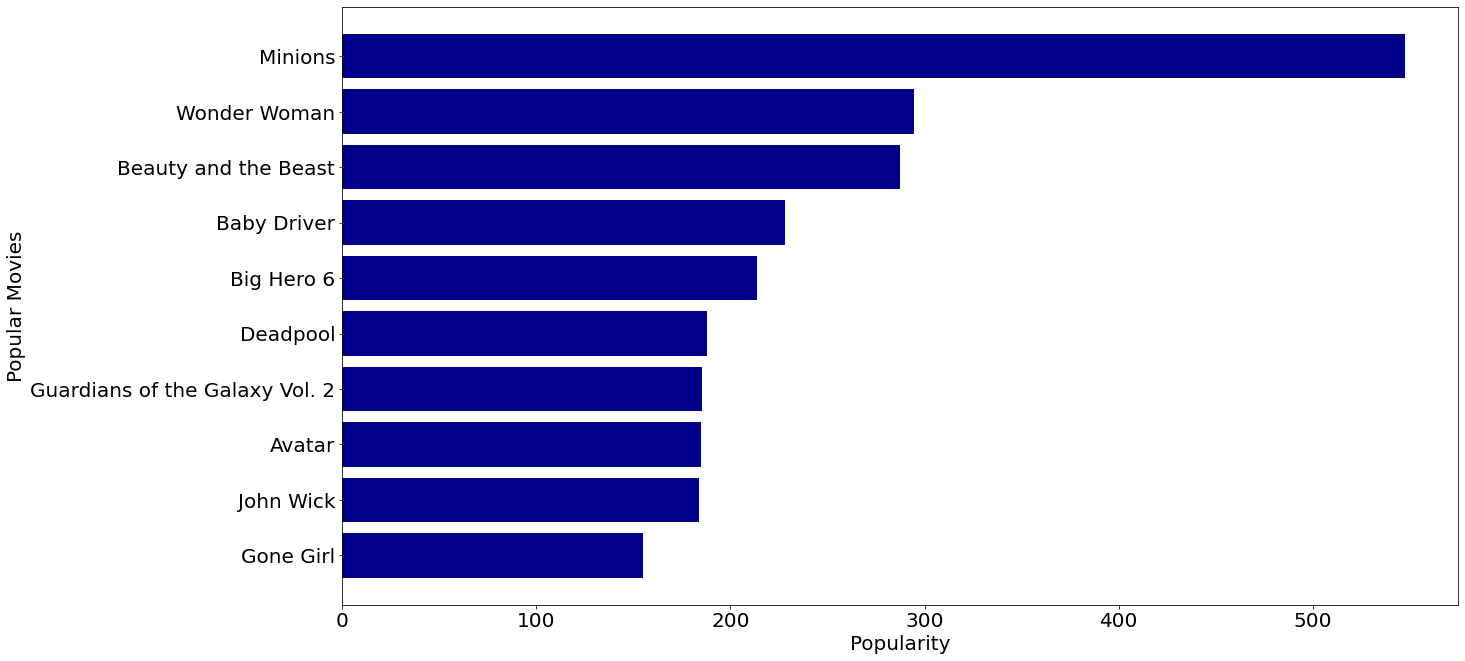

In [35]:
popular = metadata.sort_values('popularity', ascending = False)
plt.figure(figsize = (20,11))

plt.rcParams['font.size'] = '20'
plt.barh(popular['title'].head(10), popular['popularity'].head(10),align = 'center', color='darkblue')
plt.gca().invert_yaxis()
plt.xlabel('Popularity',fontsize=20)
plt.ylabel('Popular Movies',fontsize=20)

Text(0.5, 1.0, 'High budget movies')

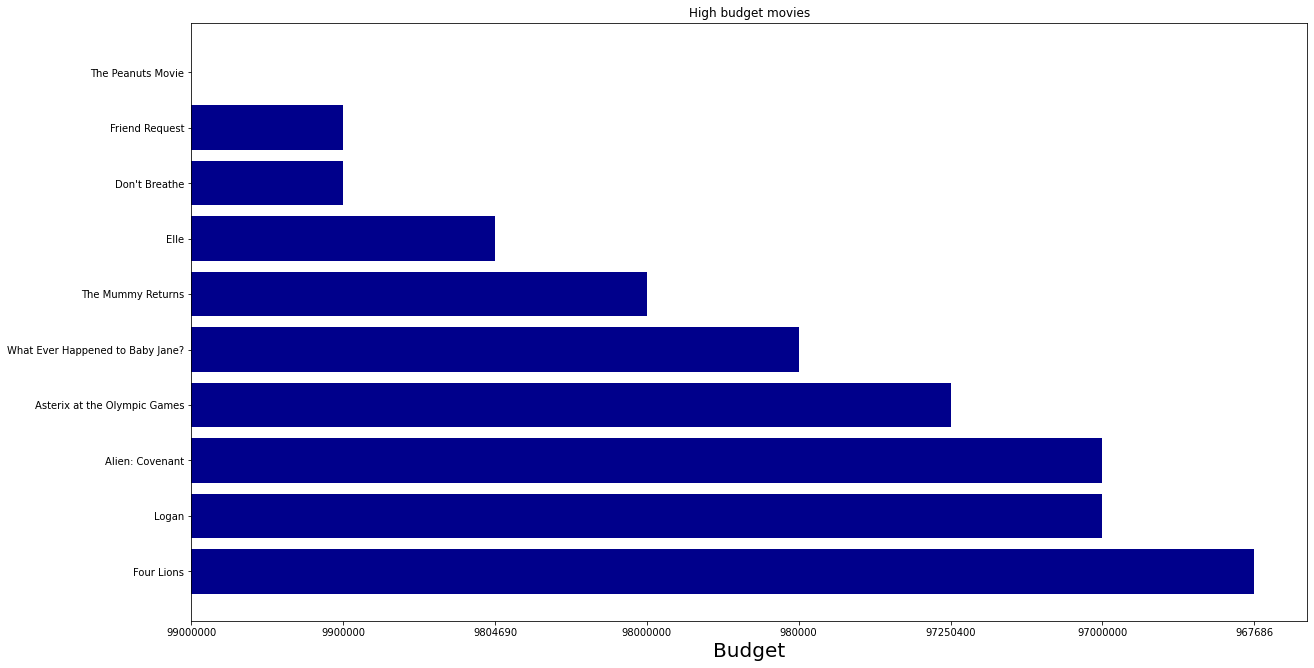

In [74]:
budget = metadata.sort_values('budget', ascending = False)
plt.figure(figsize = (20,11))

plt.rcParams['font.size'] = '10'
plt.barh(budget['title'].head(10), budget['budget'].head(10),align = 'center', color='darkblue')

plt.gca().invert_yaxis()
plt.xlabel('Budget',fontsize=20)
plt.title("High budget movies")

Text(0.5, 1.0, 'High Revenue movies')

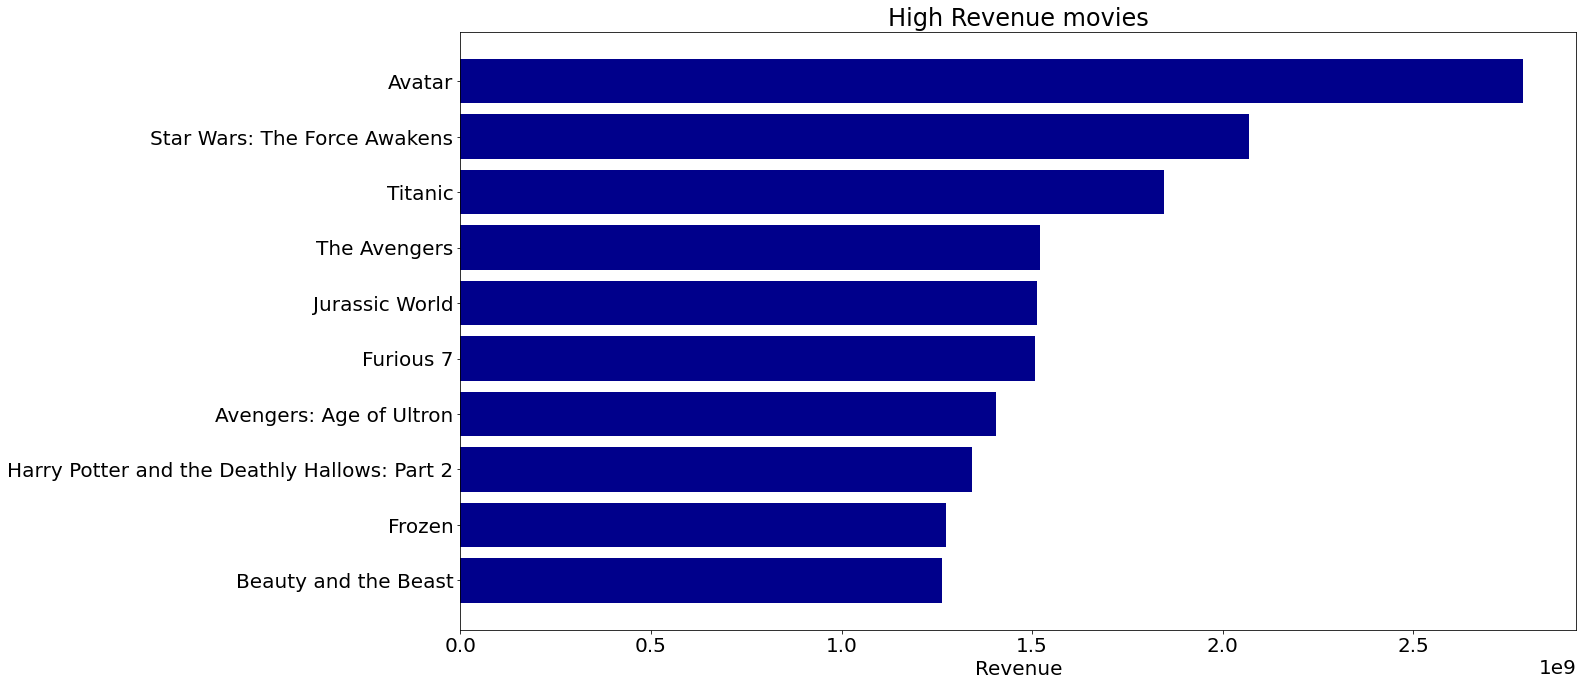

In [84]:
revenue = metadata.sort_values('revenue', ascending = False)
plt.figure(figsize = (20,11))

plt.rcParams['font.size'] = '20'
plt.barh(revenue['title'].head(10), revenue['revenue'].head(10),align = 'center', color='darkblue')
plt.gca().invert_yaxis()
plt.xlabel('Revenue',fontsize=20)
plt.title("High Revenue movies")

In [81]:
metadata[['title','runtime']]

,title,runtime
314,The Shawshank Redemption,142.0
834,The Godfather,175.0
10309,Dilwale Dulhania Le Jayenge,190.0
12481,The Dark Knight,152.0
2843,Fight Club,139.0
...,...,...
9710,Son of the Mask,94.0
12911,Disaster Movie,87.0
3471,Battlefield Earth,118.0
11557,Epic Movie,86.0


In [99]:
db = runtime[['title','runtime']].where(runtime['runtime']>60)[0:50]

In [102]:
ndb = db.dropna()

Text(0.5, 1.0, 'Low runtime movies')

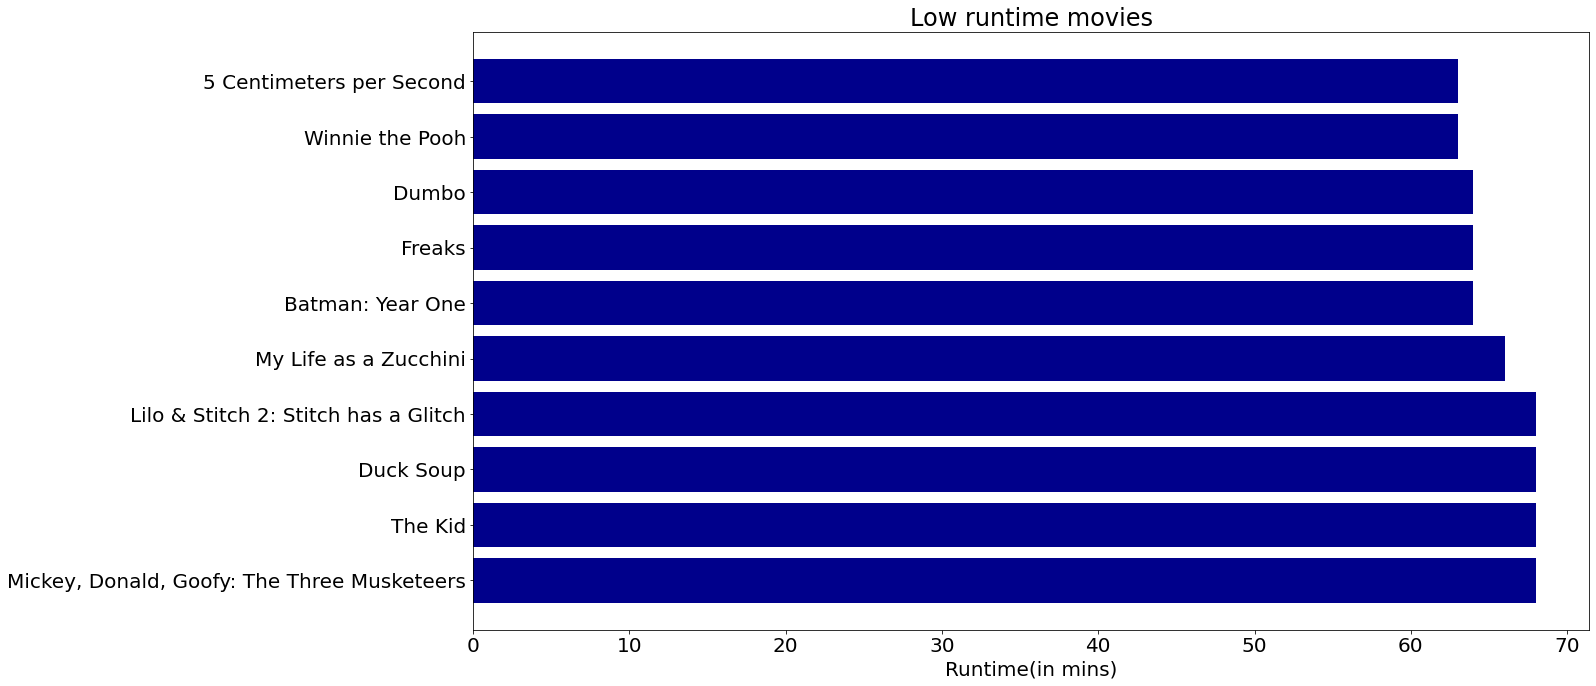

In [105]:
runtime = metadata.sort_values('runtime', ascending = True)
plt.figure(figsize = (20,11))

plt.rcParams['font.size'] = '20'
plt.barh(ndb['title'].head(10), ndb['runtime'].head(10),align = 'center', color='darkblue')
plt.gca().invert_yaxis()
plt.xlabel('Runtime(in mins)',fontsize=20)
plt.title("Low runtime movies")

In [34]:
lang = metadata['original_language'].value_counts()

In [62]:
langs = ['English', 'French', 'Japanese', 'Others']
nums = [lang.en, lang.fr, lang.ja, lang[3:].sum()]

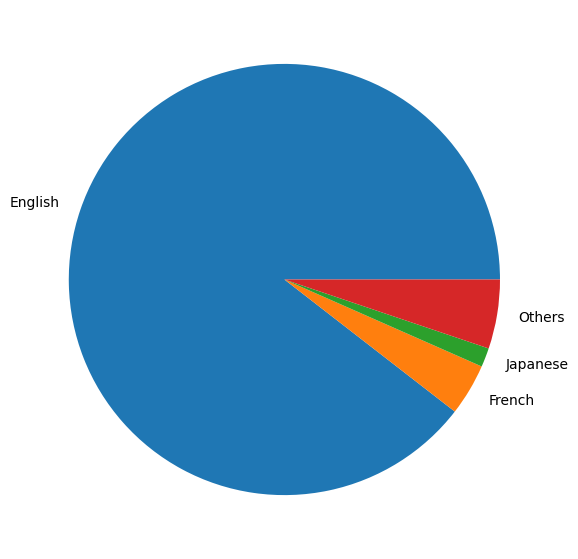

In [64]:
fig = plt.figure(figsize =(10, 7))
plt.pie(nums, labels = langs)
plt.rcParams['font.size'] = '10'
# show plot
plt.show()

## MODEL

### D-Tree

In [120]:
from sklearn.metrics import plot_confusion_matrix ,confusion_matrix, precision_score, recall_score, f1_score


Decision Tree

In [311]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
regr = DecisionTreeRegressor(max_depth=3)
regr.fit(X_train, y_train)
scoreacc = regr.score(X_test,y_test)
print(scoreacc)

0.9163124554573264


In [329]:
Y_pred = regr.predict(X_test)


MSE = mean_squared_error(y_test, Y_pred)
RMSE = mean_squared_error(y_test, Y_pred, squared=False)
MAE = mean_absolute_error(y_test, Y_pred)

print(round(MSE*100,2))
print(round(RMSE*100,2))
print(round(MAE*100,2))
print(scoreacc)

tmse.append(round(MSE*100,2))
trmse.append(round(RMSE*100,2))
tmae.append(round(MAE*100,2))
totalaccuracy.append(round(scoreacc*100,2))

3.77
19.4
14.56
0.9163124554573264


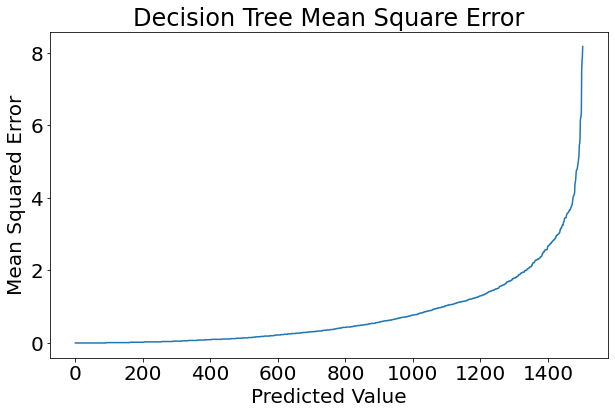

In [313]:
errors = list()
for i in range(len(y_test_list)):
    err = round(float((y_test_list[i] - Y_pred[i])**2),2)
    errors.append(err)

a = errors
a.sort()


plt.figure(figsize = (10,6))
plt.plot(a)

plt.xlabel('Predicted Value')
plt.ylabel('Mean Squared Error')
plt.title("Decision Tree Mean Square Error")
plt.show()

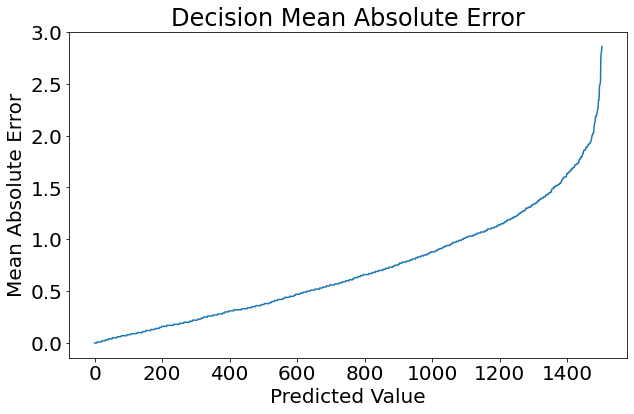

In [314]:
errors = list()
for i in range(len(y_test_list)):
    err = round(float(abs((y_test_list[i] - Y_pred[i]))),2)
    errors.append(err)

a = errors
a.sort()


plt.figure(figsize = (10,6))
plt.plot(a)

plt.xlabel('Predicted Value')
plt.ylabel('Mean Absolute Error')
plt.title("Decision Mean Absolute Error")
plt.show()

In [55]:
feature_names = ['vote_count', 'vote_average']

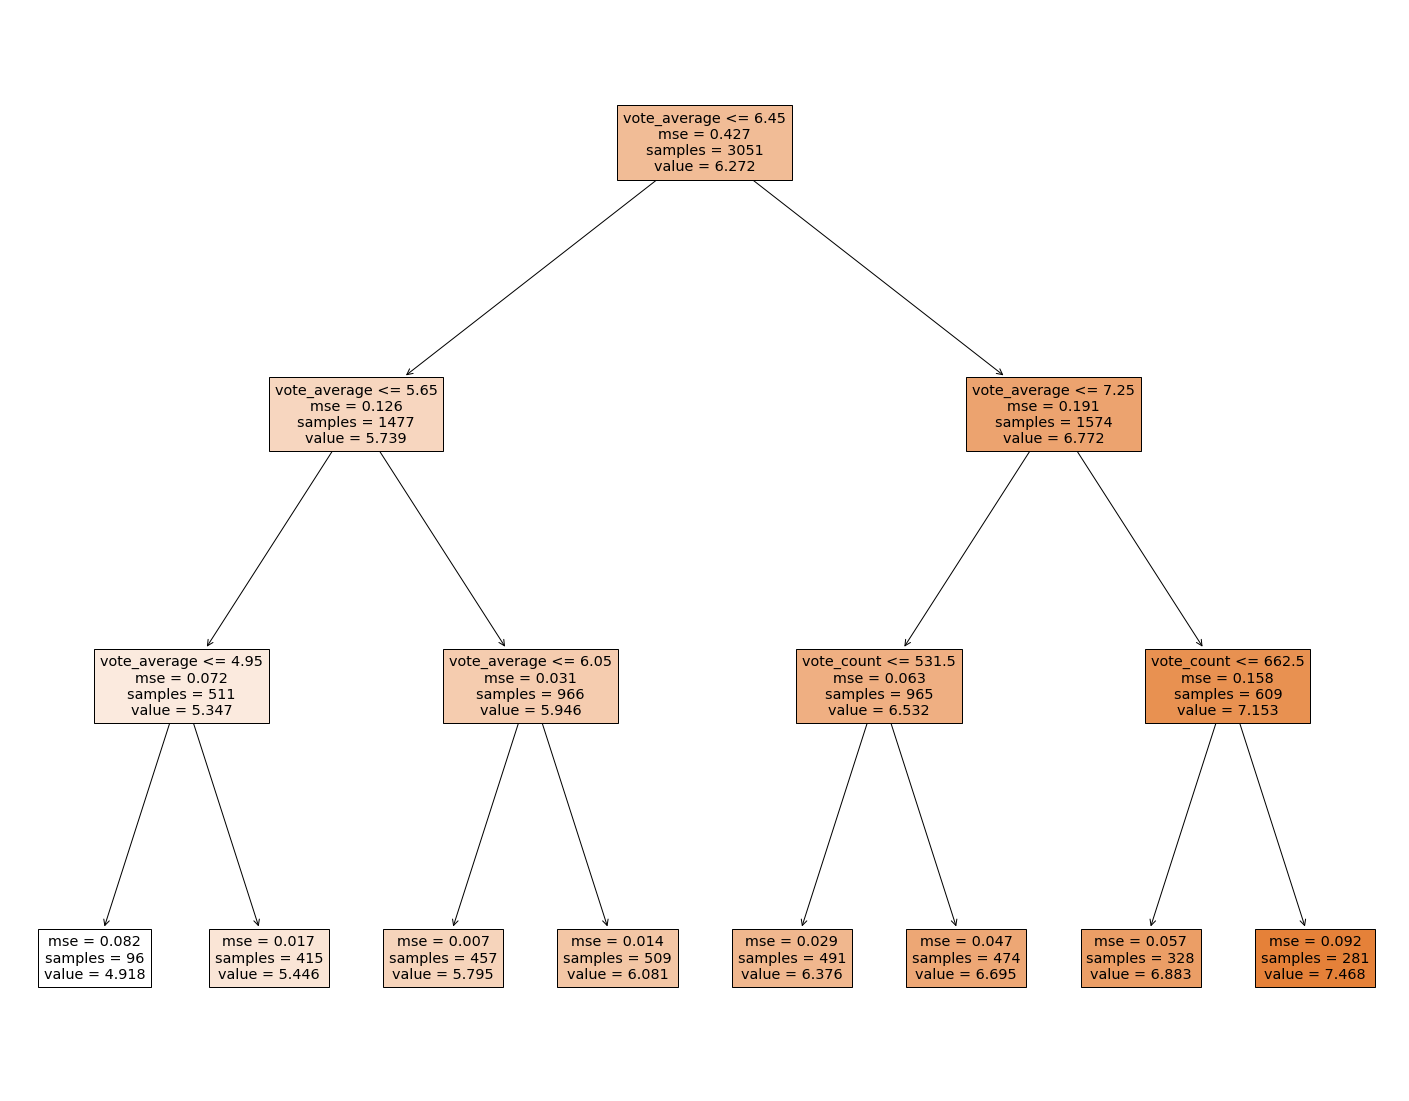

In [56]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(regr, feature_names=feature_names, filled=True)

### get_similarity

In [9]:
def get_similarity(q_movies, vectorizer = TfidfVectorizer, sim = cosine_similarity):
    #Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
    tfidf = vectorizer(stop_words='english')

    #Replace NaN with an empty string
    q_movies['overview'] = q_movies['overview'].fillna('')

    #Construct the required TF-IDF matrix by fitting and transforming the data
    tfidf_matrix = tfidf.fit_transform(q_movies['overview'])
    cosine_sim = sim(tfidf_matrix)
    return cosine_sim

In [10]:
cosine_sim = get_similarity(q_movies)

In [29]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    # idx = indices[title]
    try:
        idx = q_movies.loc[q_movies['title'] == title, 'Idx'].values[0]
    except:
        return "Movie not found"
    if idx > 14999:
        return "Movie not found"
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return q_movies['title'].iloc[movie_indices]

In [30]:
movie = 'Interstellar'
get_recommendations(movie)

'Movie not found'

In [16]:
filename = 'sentiment.pkl'
clf = pickle.load(open(filename, 'rb'))
vectorizer = pickle.load(open('tranform.pkl','rb'))

In [199]:
def get_sentiment_reviews(movie, q_movies):
    imdb_id = q_movies['imdb_id'].loc[q_movies['title']==movie].values[0]
    sauce = urllib.request.urlopen('https://www.imdb.com/title/{}/reviews?ref_=tt_ov_rt'.format(imdb_id)).read()
    soup = BeautifulSoup(sauce,'lxml')
    soup_result = soup.find_all("div",{"class":"text show-more__control"})

    reviews_list = [] # list of reviews
    reviews_status = [] # list of comments (good or bad)
    for review in soup_result:
        if review.string:
            # passing the review to our model
            movie_review_list = np.array([review.string])
            movie_vector = vectorizer.transform(movie_review_list)
            pred = clf.predict(movie_vector)
            reviews_list.append(review.string)
            reviews_status.append('Good' if pred else 'Bad')
    
    reviews = pd.DataFrame()
    reviews["reviews_list"] = reviews_list
    reviews["reviews_status"] = reviews_status
    return reviews

In [200]:
reviews = get_sentiment_reviews(movie, q_movies)

In [201]:
reviews

,reviews_list,reviews_status
0,"Confidently directed, dark, brooding, and pack...",Good
1,This movie is a work of art. The finest sequel...,Bad
2,It is just what you want for the best movie. G...,Good
3,"Dark, yes, complex, ambitious. Christopher Nol...",Good
4,"I couldn't believe ""The Dark knight"" could liv...",Bad
5,"Christopher Nolan's second bundle of joy ""The ...",Bad
6,Totally one of the greatest movie titles ever ...,Good
7,I thought Batman Begins was a very well concei...,Bad
8,A modern masterpiece of 21st Century Cinema. T...,Good
